### load data

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [2]:
from theano import *
import theano.tensor as T

In [3]:
mnist = fetch_mldata("MNIST original")
X = mnist.data.astype('float64')
y = mnist.target

In [4]:
num_class = 10   # {0,...,9}
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [5]:
train_samples = 6000

In [6]:
# 6000 1000 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=1000)

### define softmax
* [softmax with vectorized operations](https://mlxai.github.io/2017/01/09/implementing-softmax-classifier-with-vectorized-operations.html) <br> 
* [math part](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative)

In [7]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  N = X.shape[0]
  C = W.shape[1]

  f = X.dot(W)
  f -= np.matrix(np.max(f, axis=1)).T
    
  term1 = -f[np.arange(N), y]   
  sum_j = np.sum(np.exp(f), axis=1)
  term2 = np.log(sum_j)
  loss = term1 + term2
  loss /= N 
  loss += 0.5 * reg * np.sum(W * W)
  
  coef = np.exp(f) / np.matrix(sum_j).T
  coef[np.arange(N),y] -= 1
  dW = X.T.dot(coef)
  dW /= N
  dW += reg*W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

### gradient descent

In [8]:
# initialize weights
w = np.random.random((X_train.shape[1], 10))   # (784, 10)
iterations = 500
learningRate = 1e-2
losses = []
for i in range(0,iterations):
    loss, grad = softmax_loss_vectorized(w, X_train, y_train.astype(int), 1)   # lamda = 1 for regularization
    losses.append(loss)
    w = w - (learningRate * grad)
    w = np.asarray(w)
print(losses)

[array([1284.45200063, 1284.28608816, 1284.39940851, ..., 1284.38360409,
       1284.31208098, 1284.23059147]), array([1272.48021519, 1272.43205576, 1272.58660424, ..., 1272.45248505,
       1272.47253654, 1272.55652997]), array([1249.67374733, 1249.45069067, 1249.48040905, ..., 1249.40151058,
       1249.49927142, 1249.2317019 ]), array([1244.6408553 , 1244.6408553 , 1244.6408553 , ..., 1244.6408553 ,
       1244.6408553 , 1247.21453227]), array([1217.60294894, 1217.64970175, 1218.09714357, ..., 1217.69044737,
       1218.05121934, 1219.59723418]), array([1226.59498373, 1224.15666748, 1224.23890607, ..., 1224.15666748,
       1224.28433454, 1225.40642036]), array([1195.75145587, 1194.27074058, 1194.04322551, ..., 1194.18845953,
       1194.04322551, 1194.40128833]), array([1164.57333199, 1163.66305018, 1163.96046762, ..., 1163.66305018,
       1163.7839825 , 1163.66305018]), array([1136.49725433, 1136.28114078, 1136.28114078, ..., 1136.28114078,
       1136.28114078, 1136.28114078]), 

 ...]

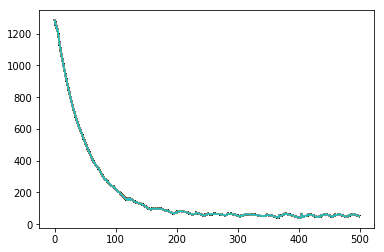

In [9]:
# check if converge
plt.plot(losses)

### Accuracy

In [18]:
w

array([[0.00550444, 0.00292337, 0.00417876, ..., 0.00014856, 0.00548935,
        0.00236862],
       [0.00592339, 0.00347343, 0.0041582 , ..., 0.00429543, 0.00145648,
        0.00091684],
       [0.00288368, 0.00279483, 0.00024047, ..., 0.00249333, 0.00100132,
        0.0030472 ],
       ...,
       [0.00191319, 0.00230232, 0.0041064 , ..., 0.00126062, 0.00084952,
        0.00549267],
       [0.00487095, 0.00365662, 0.0051311 , ..., 0.00290011, 0.00436614,
        0.00355063],
       [0.00519488, 0.00057   , 0.00460434, ..., 0.00446735, 0.00479402,
        0.00071874]])

In [35]:
w.T.shape

(10, 784)

In [33]:
X_train.T.shape

(784, 6000)

In [38]:
z = np.dot(w.T, X_train.T)
z.shape

(10, 6000)

In [40]:
def stablesoftmax(z):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftz = z - np.max(z)
    exps = np.exp(shiftz)
    return exps / np.sum(exps)

In [41]:
stablesoftmax(z)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
def getProbsAndPreds(someX, w):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

In [43]:
probs, preds = getProbsAndPreds(X_train, w)

In [44]:
probs

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
def getAccuracy(probs, preds):
    pass